## SF Fireshed Model Prep
Here we develop the geospatial and tabular inputs required to drive the simulations.

### Load required libraries
A bit overkill at the moment -- will thin this down prior to finalization

In [15]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ---- Geospatial utilities
from geoUtils import *

dataDir = 'V:/SFFireshed/'
rasters = dataDir + 'inputRasters/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

### Define the analysis extent
and look at the extent in the context of the greater geographic area. 
The SF fireshed, as its being modeled here, is roughly 43,000 ha, and contains vegetation types
ranging from Pinon-Juniper woodlands at the lower elevations, transitioning to Ponderosa Pine 
and ultimately, up to mixtures of sub-alpine fir and Engleman Spruce at higher elevations.

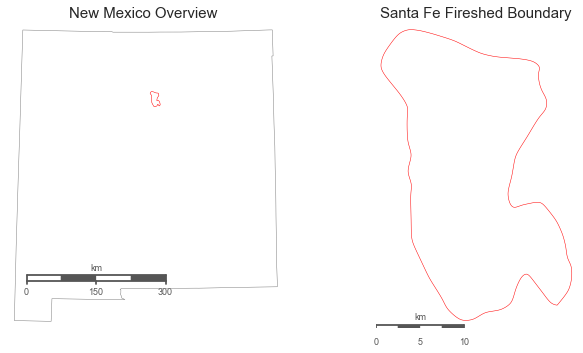

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
coords, midlat, midlon = getShpGeom(shapeDir + 'NM_NAD83.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(dataDir + 'NM_NAD83', 'NewMexico',
    color='gray', zorder=5);
m.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'SFFireshed',
    color='red', zorder=5);

m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'GSFCC_Boundary_NAD83.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'GSFCC',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.055, coords[1] + 0.00,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('New Mexico Overview', fontsize = 15)
ax2.set_title('Santa Fe Fireshed Boundary', fontsize = 15)
plt.tight_layout()
sns.set_style('white')
sns.despine(left = True, bottom = True)

### Ecoregion creation
LANDIS-II requires the landscape be separated into edaphically and climatically distinct chunks. For this study we used STATSGO and USGS data to delineate the landscape into areas of unique soil composition, and distinct elevation bands that follow clear ecotones across the landscape. The logic here being that vegetation transitions and climate are well correlated with elevation across this fireshed. We then joined the soils components with the elevation bands to create the unique ecoregions for the fireshed.

#### Import and fix up the raster data
I classified elevation (binned into four distinct bands that correlate with vegetation ecotones) on a scale of 100 to 400. These thematic lables correspond to XX, XX, XX, and XX meter elevation contours. In this manner, the six distinct soil types (here represented as values 1-6, described below) can be crossed with each elevation band to create unique soil, elevation combinations -- here referred to as ecoregions.

In [30]:
elevation  = importRaster(rasters + 'elevationBins.tif')
soils      = importRaster(rasters + 'soilBins.tif')
ecoregions = importRaster(rasters + 'SFF_ecoregions.tif')

soils[soils == 255] = 0

We need to do some color map trickery in order to visualize the ecoregions here, given that the thematic values are discontinuous and range from 105-405, with a sort of macro/micro class setup that I designed to make the raster math simple

In [51]:
from matplotlib import colors
cmap = colors.ListedColormap(['white','#969696','#636363',
                              '#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c',
                              '#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f',
                              '#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'])
bounds=[0,105,106,
        201,202,203,204,205,206,
        301,302,303,304,305,306,
        401,402,403,404,405]
norm = colors.BoundaryNorm(bounds, cmap.N)

####Visualize the three rasters 

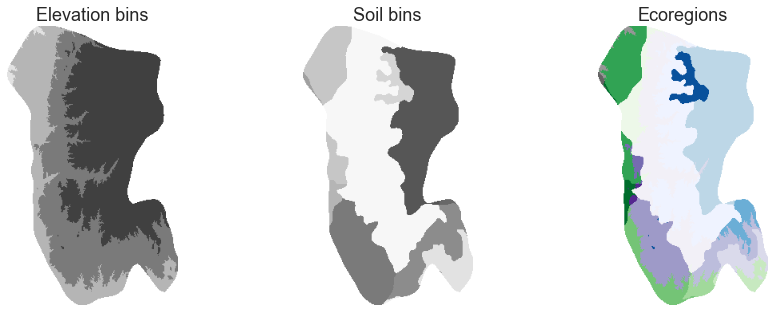

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elevation,  vmin = 0, vmax = 500, ax = ax1)
plotRaster(soils,      vmin = 0, vmax = 15,  ax = ax2)
plotRaster(ecoregions, cmap = cmap, norm = norm, ax = ax3)

ax1.set_title('Elevation bins')
ax2.set_title('Soil bins')
ax3.set_title('Ecoregions')